In [211]:
# =============================================================================
# ENVIRONMENT CHECK - Run this cell first!
# =============================================================================
# This cell verifies that the DEGIS environment is properly set up
# Make sure you've run ./setup_server_fixed.sh first!

import sys
import os

# Check if we're in the right environment
if 'degis-env' in sys.executable:
    print("✅ DEGIS environment is active")
    print(f"🐍 Python: {sys.executable}")
else:
    print("⚠️  Warning: DEGIS environment not detected")
    print("   Please run: ./setup_server_fixed.sh")
    print("   Then activate: source degis-env/bin/activate")

# Check if DEGIS package is available
try:
    import degis
    print("✅ DEGIS package is available")
except ImportError:
    print("❌ DEGIS package not found")
    print("   Please run: ./setup_server_fixed.sh")

print("\n🚀 Ready to start image generation!")


✅ DEGIS environment is active
🐍 Python: /data/degis/degis-env/bin/python
✅ DEGIS package is available

🚀 Ready to start image generation!


In [2]:
# =============================================================================
# IMPORTS - Run this after the setup cell above
# =============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

# Import DEGIS package components
from degis import IPAdapterXLGenerator, load_trained_color_head, get_color_embedding
from degis.shared.utils import create_control_edge_pil, plot_color_palette, display_images_grid, display_comparison_grid

print("✅ All imports successful!")
print("🎨 Ready for high-quality image generation with IP-Adapter XL!")


✅ All imports successful!
🎨 Ready for high-quality image generation with IP-Adapter XL!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import the DEGIS package
from degis.data.dataset import UnifiedImageDataset

# Import IP-Adapter XL with DEGIS patches
import ip_adapter_patch  # This applies the DEGIS monkey patches
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline
from degis.shared.image_features.color_histograms import compute_color_histogram, compute_lab_histogram
from degis.shared.utils.image_utils import create_control_edge_pil
import geomloss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
csv_path = "/data/thesis/laion_5m_manifest.csv"
embeddings_path = "/data/thesis/models/hf_xl_laion_5m_embeddings.npy" # || YOUR_CUSTOM_PATH
colour_path = "/data/thesis/data/laion_5m_color_histograms_lab_514.npy" # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/evaluation_runs/laion_5m_xl_lab514_tk20_b4096/best_color_head_tmp.pth" # || YOUR_CUSTOM_PATH
precomputed_adimagenet_edge_maps_path = "/data/thesis/data/adimagenet_edge_maps.npy" # || YOUR_CUSTOM_PATH


# ip_ckpt = "/data/thesis/models/ip-adapter_sd15.bin"
image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"
# stable_diffusion_model_id = "runwayml/stable-diffusion-v1-5"

In [5]:
from degis.inference import load_trained_color_head
# Load datasets
df = pd.read_csv(csv_path)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(precomputed_adimagenet_edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1280)
Loaded histograms: (3336240, 514)
Loaded edge maps: (2080, 50176)
✓ Color head loaded successfully


In [6]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter XL generator
generator = IPAdapterXLGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet_id=controlnet_id,
    ip_ckpt=None,  # Update path as needed
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter XL pipeline setup complete")


Using cache directory: /data/hf-cache


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IP-Adapter sdxl checkpoint not found at h94/IP-Adapter
✓ Downloaded IP-Adapter sdxl checkpoint


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ IP-Adapter XL pipeline setup complete


In [7]:
# import torch, gc

# def generate_from_dataset_id_xl(
#     colour_index: int,
#     layout_index: int,
#     prompt: str = "a cat playing with a ball",
#     guidance_scale: float = 6.5,
#     steps: int = 40,
#     controlnet_conditioning_scale: float = 0.8,
#     num_samples: int = 1,
#     attn_ip_scale: float = 0.8,
#     text_token_scale: float = 1.0,
#     ip_token_scale: float = None,
#     ip_uncond_scale: float = 0.0,
#     zero_ip_in_uncond: bool = True,
#     colour_only: bool = True,
# ):
#     """Generate images using IP-Adapter XL with advanced controls."""
#     import torch, gc
#     gc.collect()
#     torch.cuda.empty_cache()
#     # Get original image for display
#     img_t, _ = colour_dataset[colour_index]
#     pil_img = transforms.ToPILImage()(img_t)
    
#     # Get CLIP embedding and compute color embedding
#     z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
#     color_embedding = get_color_embedding(color_head, z_clip)
    
#     # Create control image from edge data
#     control_image = create_control_edge_pil(edge_maps[layout_index], size=512)
    
#     if colour_only:
#         ref = color_embedding
#     else:
#         ref = z_clip
#     # Generate images with IP-Adapter XL
#     images = generator.generate(
#         pil_img=pil_img,
#         # color_embedding=ref,
#         control_image=control_image,
#         prompt=prompt,
#         # negative_prompt=(
#         #     "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
#         #     "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
#         #     "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
#         #     "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
#         # ),
#         num_samples=num_samples,
#         guidance_scale=guidance_scale,
#         num_inference_steps=steps,
#         controlnet_conditioning_scale=controlnet_conditioning_scale,
#         # IP-Adapter XL specific parameters
#         attn_ip_scale=attn_ip_scale,
#         text_token_scale=text_token_scale,
#         ip_token_scale=ip_token_scale,
#         ip_uncond_scale=ip_uncond_scale,
#         zero_ip_in_uncond=zero_ip_in_uncond,
#     )
    
#     # Display results
#     comparison = display_comparison_grid(
#         original=pil_img,
#         control=control_image,
#         generated=images,
#         cols=3
#     )
#     display(comparison)
    
#     return images

# print("✓ IP-Adapter XL generation function defined")

In [8]:
# # ==== Aligned GT vs Pred top-20 + IMAGE (first 10) ====
# import os, numpy as np, torch, matplotlib.pyplot as plt, pandas as pd
# from skimage.color import lab2rgb
# BINS      = 8
# TOP_K     = 14
# SPACE = "lab"
# hist = histograms
# emb = embeddings
# HIST_KIND = "lab514"   # "rgb512" | "lab514" | "hcl514"
# sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05, backend="tensorized")
# def _top_palette(vec, bins=BINS, top_k=TOP_K, space=SPACE, c_max=150.0):
#     v = vec.detach().cpu().numpy() if isinstance(vec, torch.Tensor) else np.asarray(vec)
#     core = v[:bins**3]  # ignore the last 2 BW slots for palette picking
#     idxs = np.argsort(core)[-top_k:][::-1]
#     cols = []
#     if space == "rgb":
#         for flat in idxs:
#             ri = flat // (bins*bins); gi = (flat // bins) % bins; bi = flat % bins
#             cols.append(((ri+0.5)/bins, (gi+0.5)/bins, (bi+0.5)/bins))
#     elif space == "lab":
#         for flat in idxs:
#             Li = flat // (bins*bins); ai = (flat // bins) % bins; bi = flat % bins
#             L = (Li+0.5)/bins*100.0
#             a = (ai+0.5)/bins*255.0 - 128.0
#             b = (bi+0.5)/bins*255.0 - 128.0
#             cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
#     elif space == "hcl":
#         for flat in idxs:
#             Li = flat // (bins*bins); Ci = (flat // bins) % bins; Hi = flat % bins
#             L = (Li+0.5)/bins*100.0
#             C = (Ci+0.5)/bins*c_max
#             H = (Hi+0.5)/bins*360.0
#             a = C*np.cos(np.deg2rad(H)); b = C*np.sin(np.deg2rad(H))
#             cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
#     else:
#         raise ValueError("space must be 'rgb' | 'lab' | 'hcl'")
#     return cols, core[idxs]

# def _plot_palette(ax, colors, values, title):
#     for i, (c, v) in enumerate(zip(colors, values)):
#         ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
#         ax.text(i+0.5, -0.08, f"{v:.3f}", ha="center", va="top", fontsize=7)
#     ax.set_xlim(0, len(colors)); ax.set_ylim(0,1); ax.axis("off")
#     ax.set_title(title, fontsize=12)

# def show_aligned(i, dataset):
#     # image from the SAME dataset (guarantees correct ordering)
#     img_t, _ = dataset[i]                    # [3,224,224] float [0,1]
#     img_np   = img_t.permute(1,2,0).numpy()  # HWC

#     # GT and Pred from aligned arrays / model
#     h_gt = torch.from_numpy(hist[i]).to(device)
#     z    = torch.from_numpy(emb[i]).to(device).unsqueeze(0)

#     with torch.no_grad():
#         _, p, _ = color_head(z)
#         p = p.squeeze(0)
#         p = p / (p.sum() + 1e-8)
#         g = h_gt / (h_gt.sum() + 1e-8)
#         l1  = torch.sum(torch.abs(p-g)).item()
#         cos = torch.nn.functional.cosine_similarity(p, g, dim=0).item()
#         emd = sinkhorn(p.unsqueeze(0), g.unsqueeze(0)).item() if sinkhorn is not None else None

#     gt_cols, gt_vals = _top_palette(g)
#     pr_cols, pr_vals = _top_palette(p)

#     # draw
#     fig, axes = plt.subplots(2, 2, figsize=(14, 5), gridspec_kw={"height_ratios":[2,1]})
#     axes[0,0].imshow(img_np); axes[0,0].axis("off")
#     basename = os.path.basename(str(dataset.df.iloc[i]["file_path"]))
#     # axes[0,0].set_title(f"idx={i}  ({basename})")
#     axes[0,0].set_title(f"EMD={emd:.4f}")
#     # if emd is not None: txt += f"\nEMD = {emd:.4f}"

#     axes[0,1].axis("off")
#     txt = f"Histogram kind: {HIST_KIND}\nL1 = {l1:.4f}\nCosine = {cos:.4f}"
#     if emd is not None: txt += f"\nEMD = {emd:.4f}"
#     axes[0,1].text(0.02, 0.85, txt, fontsize=12, va="top")

#     _plot_palette(axes[1,0], pr_cols, pr_vals, f"Pred top-bins")
#     _plot_palette(axes[1,1], gt_cols, gt_vals, f"GT top-{TOP_K}")
#     plt.tight_layout(); plt.show()

# for i in range(100000, 100020):
#     show_aligned(i, colour_dataset)
# # for i in range(1000, 1010):
# #     show_aligned(i, colour_dataset)

In [9]:
# generate_from_dataset_id_xl(
#     colour_index=1008,
#     layout_index=71,
#     prompt="a car, advertisement style, professional photography",
#     guidance_scale=15,
#     steps=50,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.0,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
#     colour_only=True,
# )

In [10]:
# generate_from_dataset_id_xl(
#     colour_index=1008,
#     layout_index=71,
#     prompt="a car, advertisement style, professional photography",
#     guidance_scale=15,
#     steps=50,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.0,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
#     colour_only=False,
# )

In [11]:
# generate_from_dataset_id_xl(
#     colour_index=1000,
#     layout_index=71,
#     prompt="a car, reaslistic background, professional photography",
#     guidance_scale=15,
#     steps=100,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.0,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
# )

In [12]:
# generate_from_dataset_id_xl(
#     colour_index=1000,
#     layout_index=381,
#     prompt="a car, no text, realistic background, professional photography",
#     guidance_scale=15,
#     steps=100,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.0,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
# )

In [13]:
# for i in [6, 21, 33, 45, 67, 104, 141, 177, 232, 382, 311, 438, 440, 503]:
#     generate_from_dataset_id_xl(
#     colour_index=1008,
#     layout_index=i,
#     prompt="identical hoodies, advertisement style, professional photography",
#     guidance_scale=15,
#     steps=50,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.5,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
# )

In [14]:
import torch, gc
from degis.inference import generate_by_style, generate_by_colour_emd_constrained
from degis.shared.utils.visualization import visualize_generation_comparison, create_generation_metrics
from degis.shared.utils.image_utils import create_control_edge_pil
from degis.inference.core_generation import get_color_embedding

def generate_comparison_snippet(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
    # EMD generation parameters
    target_emd_threshold: float = 0.1,
    max_attempts: int = 20,
    top_k: int = 20,
    color_space: str = None,
):
    """Simple snippet to generate both style and EMD images with visualization."""
    
    # Clear GPU memory
    gc.collect()
    torch.cuda.empty_cache()
    
    print(f"🎨 Generating comparison for colour_index={colour_index}, layout_index={layout_index}")
    print(f"📝 Prompt: '{prompt}'")
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = create_control_edge_pil(edge_maps[layout_index], size=512)
    
    # Compute color histogram for EMD constraint
    from degis.inference.generation_functions import compute_histogram_for_color_space, detect_color_space
    color_histogram = compute_histogram_for_color_space(pil_img, color_space or "lab", bins=8)
    if color_space is None:
        color_space = detect_color_space(color_histogram)
    
    print(f"📊 Color space: {color_space}, Histogram shape: {color_histogram.shape}")
    
    # 1. Style Generation (one-shot)
    print("\n�� Running style generation...")
    import time
    start_time = time.time()
    
    style_images = generate_by_style(
        generator=generator,
        pil_image=pil_img,
        control_image=control_image,
        prompt=prompt,
        negative_prompt=(
            "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
            "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
            "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
            "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
        ),
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond
    )
    style_time = time.time() - start_time
    style_generated_image = style_images[0]
    
    # Calculate metrics for style generation
    from degis.inference.generation_functions import calculate_emd_distance_topk, calculate_cosine_similarity
    style_emd = calculate_emd_distance_topk(color_histogram, compute_histogram_for_color_space(style_generated_image, color_space, bins=8))
    style_cosine = calculate_cosine_similarity(prompt, style_generated_image)
    
    style_metrics = create_generation_metrics(
        generation_time=style_time,
        emd_score=style_emd,
        cosine_score=style_cosine
    )
    
    print(f"✅ Style generation: {style_time:.2f}s, EMD: {style_emd:.4f}, Cosine: {style_cosine:.4f}")
    
    # 2. EMD-Constrained Generation
    print("\n🔄 Running EMD-constrained generation...")
    start_time = time.time()
    
    emd_images, emd_score, emd_cosine, attempts = generate_by_colour_emd_constrained(
        generator=generator,
        color_embedding=color_embedding,
        control_image=control_image,
        original_histogram=color_histogram,
        prompt=prompt,
        target_emd_threshold=target_emd_threshold,
        max_attempts=max_attempts,
        top_k=top_k,
        color_space=color_space,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
        verbose=True
    )
    emd_time = time.time() - start_time
    emd_generated_image = emd_images[0]
    
    emd_metrics = create_generation_metrics(
        generation_time=emd_time,
        emd_score=emd_score,
        cosine_score=emd_cosine,
        attempts=attempts
    )
    
    print(f"✅ EMD generation: {emd_time:.2f}s, EMD: {emd_score:.4f}, Cosine: {emd_cosine:.4f}, Attempts: {attempts}")
    
    # 3. Create comprehensive visualization
    print("\n🎨 Creating comprehensive visualization...")
    
    visualization = visualize_generation_comparison(
        color_source_image=pil_img,
        edge_map_image=control_image,
        style_generated_image=style_generated_image,
        emd_generated_image=emd_generated_image,
        color_histogram=color_histogram,
        color_space=color_space,
        style_metrics=style_metrics,
        emd_metrics=emd_metrics,
        grid_size=512,
        font_size=16
    )
    
    print(f"✅ Visualization created: {visualization.size}")
    print(f"�� Final comparison:")
    print(f"   Style: EMD={style_emd:.4f}, Cosine={style_cosine:.4f}")
    print(f"   EMD:   EMD={emd_score:.4f}, Cosine={emd_cosine:.4f}")
    
    # Display the visualization
    from IPython.display import display
    display(visualization)
    
    return visualization, style_metrics, emd_metrics

# Usage example:
# visualization, style_metrics, emd_metrics = generate_comparison_snippet(
#     colour_index=1008,
#     layout_index=71,
#     prompt="a car, advertisement style, professional photography",
#     guidance_scale=15,
#     steps=50,
#     controlnet_conditioning_scale=0.4,
#     num_samples=1,
#     attn_ip_scale=0.6,
#     text_token_scale=1.0,
#     ip_token_scale=0.4,
#     ip_uncond_scale=0.0,
#     zero_ip_in_uncond=False,
#     target_emd_threshold=0.1,
#     max_attempts=20
# )

🎨 Generating comparison for colour_index=1008, layout_index=71
📝 Prompt: 'a car, advertisement style, professional photography'
Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 514])
  - Probs shape: torch.Size([1, 514])
  - Color embedding shape: torch.Size([1, 1280])
📊 Color space: lab, Histogram shape: (514,)

�� Running style generation...


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True
✅ Style generation: 6.88s, EMD: 0.0300, Cosine: 0.2850

🔄 Running EMD-constrained generation...
🎨 EMD-constrained generation: Using pre-computed color embedding
📊 Color space: lab, Target EMD: 0.02


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP model already loaded. Preprocess: True
CLIP model already loaded. Preprocess: True
✅ EMD generation: 141.98s, EMD: 0.0268, Cosine: 0.2969, Attempts: 20

🎨 Creating comprehensive visualization...
✅ Visualization created: (2499, 1497)
�� Final comparison:
   Style: EMD=0.0300, Cosine=0.2850
   EMD:   EMD=0.0268, Cosine=0.2969


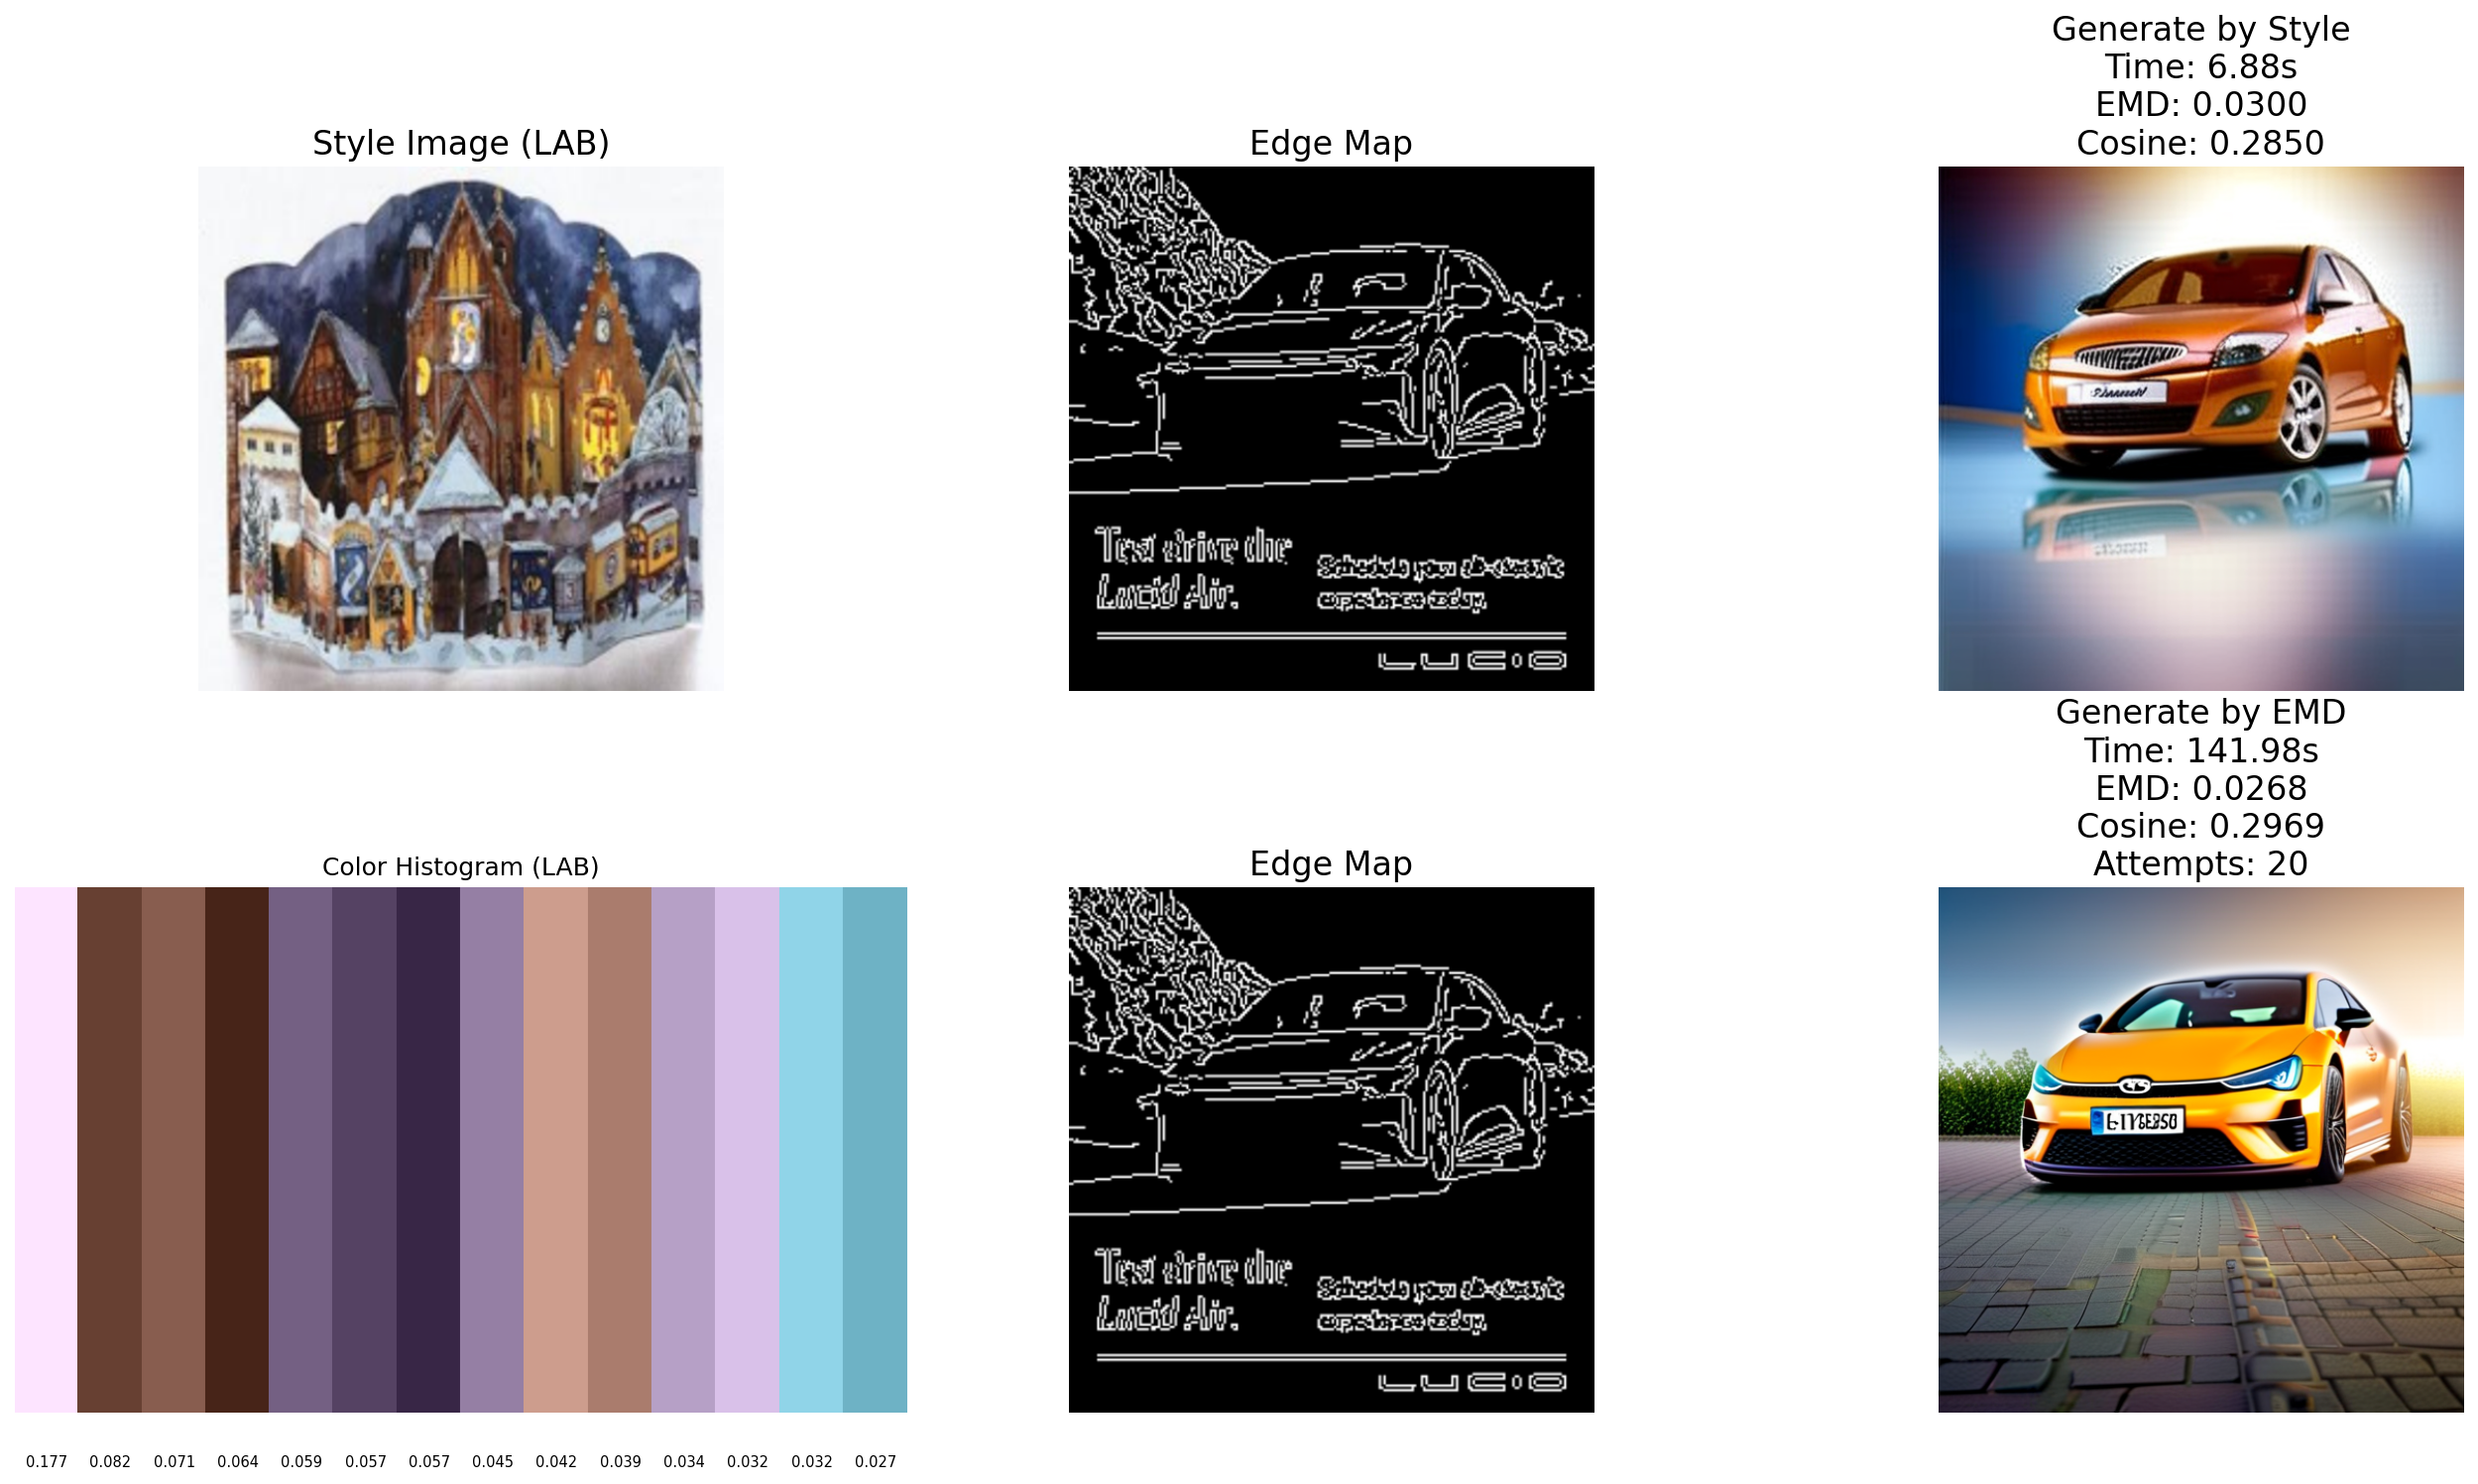

In [17]:
# Usage example:
visualization, style_metrics, emd_metrics = generate_comparison_snippet(
    colour_index=1008,
    layout_index=71,
    prompt="a car, advertisement style, professional photography",
    guidance_scale=15,
    steps=50,
    controlnet_conditioning_scale=0.3,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.0,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=False,
    target_emd_threshold=0.02,
    max_attempts=20
)